In [90]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano

from keras.datasets import cifar10
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#encoding_dim = 3
encoding_dim = 40


# this is our input placeholder
input_img = Input(shape=(3072,))
# "encoded" is the encoded representation of the input
encoded = Dense(2800, activation='relu')(input_img)  
encoded = Dense(1800, activation='relu')(encoded)  
encoded = Dense(1200, activation='relu')(encoded)  
encoded = Dense(400, activation='relu')(encoded)  
encoded = Dense(300, activation='relu')(encoded)  
encoded = Dense(192, activation='relu')(encoded)  
encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(192, activation='relu')(encoded)  
decoded = Dense(300, activation='relu')(decoded)  
decoded = Dense(400, activation='relu')(decoded)  
decoded = Dense(1200, activation='relu')(decoded)  
decoded = Dense(1800, activation='relu')(decoded)  
decoded = Dense(2800, activation='sigmoid')(decoded)  
decoded = Dense(3072, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


In [91]:
print (autoencoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_45 (Dense)                 (None, 2800)          8604400     input_23[0][0]                   
____________________________________________________________________________________________________
dense_46 (Dense)                 (None, 1800)          5041800     dense_45[0][0]                   
____________________________________________________________________________________________________
dense_47 (Dense)                 (None, 1200)          2161200     dense_46[0][0]                   
___________________________________________________________________________________________

In [70]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [71]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 2800)          8604400     input_22[0][0]                   
____________________________________________________________________________________________________
dense_28 (Dense)                 (None, 2200)          6162200     dense_27[0][0]                   
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 1800)          3961800     dense_28[0][0]                   
___________________________________________________________________________________________

In [72]:
from keras.optimizers import *

#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #around 40% test accuracy


In [73]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [74]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [75]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [76]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(len(x_train))
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)
print (x_train.dtype)
print (x_test.dtype)
print (x_train)
print (x_test)

50000
(50000, 3072)
(10000, 3072)
(50000,)
(10000,)
float32
float32
[[ 0.23137255  0.24313726  0.24705882 ...,  0.48235294  0.36078432
   0.28235295]
 [ 0.60392159  0.69411767  0.73333335 ...,  0.56078434  0.52156866
   0.56470591]
 [ 1.          1.          1.         ...,  0.3137255   0.33725491
   0.32941177]
 ..., 
 [ 0.13725491  0.69803923  0.92156863 ...,  0.04705882  0.12156863
   0.19607843]
 [ 0.74117649  0.82745099  0.94117647 ...,  0.7647059   0.74509805
   0.67058825]
 [ 0.89803922  0.89803922  0.93725491 ...,  0.63921571  0.63921571
   0.63137257]]
[[ 0.61960787  0.43921569  0.19215687 ...,  0.08235294  0.26274511
   0.43137255]
 [ 0.92156863  0.92156863  0.92156863 ...,  0.72941178  0.78431374
   0.78039217]
 [ 0.61960787  0.74509805  0.87058824 ...,  0.02745098  0.03137255
   0.02745098]
 ..., 
 [ 0.07843138  0.05882353  0.04705882 ...,  0.09803922  0.07843138
   0.18431373]
 [ 0.09803922  0.15686275  0.04705882 ...,  0.36078432  0.47058824
   0.3137255 ]
 [ 0.28627452  

In [77]:
nfold=5
nb_epoch=50
batch_size=128
random_state =1236

In [78]:
kfold_weights_path = os.path.join('weights_kfold_' + str(nfold) + 
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size)
                                  +'.h5')
print(kfold_weights_path)

weights_kfold_5_epoch_50_batch_128.h5


In [79]:
kf = KFold(len(x_train), n_folds=nfold, shuffle=True, random_state=random_state)
print(kf)

sklearn.cross_validation.KFold(n=50000, n_folds=5, shuffle=True, random_state=1236)


In [80]:
train_full_encoded_imgs = np.zeros(shape=[x_train.shape[0],encoding_dim])
print(train_full_encoded_imgs.shape)

test_full_encoded_imgs = np.zeros(shape=[x_test.shape[0],encoding_dim])
test_full_decoded_imgs = np.zeros(shape=[x_test.shape[0],x_train.shape[1]])
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)

(50000, 40)
(10000, 40)
(10000, 3072)


In [81]:
os.path.isfile(kfold_weights_path)

True

In [82]:
num_fold = 0
restore_from_last_checkpoint=0
for train_index,valid_index in kf:
    s_train,s_valid  = x_train[train_index], x_train[valid_index]
    
    #noise_factor = 0.1
    #s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
    #s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

    #s_train_noisy = np.clip(s_train_noisy, 0., 1.)
    #s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)
    #y_train, y_test = y[train_index], y[test_index]
    
    num_fold += 1
    print('\n\nStart KFold number {} from {}'.format(num_fold, nfold))
    print('Split train: ', len(s_train), len(s_train))
    print('Split valid: ', len(s_train), len(s_valid))

    if not os.path.isfile(kfold_weights_path) or restore_from_last_checkpoint == 0:
        callbacks = [
                EarlyStopping(monitor='val_acc', patience=1, verbose=1),
                ModelCheckpoint(kfold_weights_path, monitor='val_acc', save_best_only=True, verbose=1),
        ]
        autoencoder.fit(s_train, s_train,
                nb_epoch=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(s_valid, s_valid),
                callbacks=callbacks)
    #if os.path.isfile(kfold_weights_path):
    #    autoencoder.load_weights(kfold_weights_path)
    
    # Store train predictions
    train_encoded_imgs = encoder.predict(x_train,batch_size=batch_size, verbose=1)
    train_full_encoded_imgs = np.add(train_full_encoded_imgs,train_encoded_imgs)

    
    # Store test predictions
    test_encoded_imgs = encoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_encoded_imgs = np.vstack([full_encoded_imgs,encoded_imgs])
    test_full_encoded_imgs = np.add(test_full_encoded_imgs,test_encoded_imgs)
    #full_encoded_imgs.append(encoded_imgs)
    #print(full_encoded_imgs.shape)
    
    test_decoded_imgs = autoencoder.predict(x_test,batch_size=batch_size, verbose=1)
    #full_decoded_imgs = np.vstack([full_decoded_imgs,decoded_imgs])
    test_full_decoded_imgs = np.add(test_full_decoded_imgs,test_decoded_imgs)






Start KFold number 1 from 5
Split train:  40000 40000
Split valid:  40000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 111s - loss: 0.6896 - acc: 5.0000e-04 - val_loss: 0.6895 - val_acc: 8.0000e-04
Epoch 2/50
40000/40000 [==============================] - 109s - loss: 0.6892 - acc: 6.0000e-04 - val_loss: 0.6893 - val_acc: 4.0000e-04
Epoch 3/50
39936/40000 [============================>.] - ETA: 0s - loss: 0.6891 - acc: 4.0064e-04Epoch 00002: early stopping
Epoch 00002: val_acc did not improve
10000/10000 [==============================] - 3s     


Start KFold number 2 from 5
Split train:  40000 40000
Split valid:  40000 10000
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 111s - loss: 0.6891 - acc: 5.2500e-04 - val_loss: 0.6893 - val_acc: 3.0000e-04
Epoch 2/50
40000/40000 [==============================] - 111s - loss: 0.6891 - acc: 4.2500e-04 - val_loss:

In [83]:
print(test_full_encoded_imgs.shape)
print(test_full_decoded_imgs.shape)
print(test_full_encoded_imgs)
print(test_full_decoded_imgs)


(10000, 40)
(10000, 3072)
[[ 0.          0.          0.         ...,  0.          0.          0.37930132]
 [ 0.          0.          0.         ...,  0.          0.          0.30364646]
 [ 0.          0.          0.         ...,  0.          0.          0.22836875]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.42249385]
 [ 0.          0.          0.         ...,  0.          0.          0.21044364]
 [ 0.          0.          0.         ...,  0.          0.          0.45529963]]
[[ 2.56769091  2.66719753  2.60179967 ...,  2.49122021  2.47388908
   2.26121587]
 [ 2.56769091  2.66719753  2.60179967 ...,  2.49122021  2.4738892
   2.26121581]
 [ 2.56769091  2.66719764  2.60179967 ...,  2.49122021  2.47388914
   2.26121587]
 ..., 
 [ 2.56769097  2.66719764  2.60179961 ...,  2.49122033  2.47388914
   2.26121596]
 [ 2.56769091  2.66719764  2.60179961 ...,  2.49122027  2.47388914
   2.2612159 ]
 [ 2.56769091  2.66719764  2.60179961 ...,  2.49122027  2.47388908
   

In [84]:
test_res_encoded_imgs = test_full_encoded_imgs/nfold
test_res_decoded_imgs = test_full_decoded_imgs/nfold
print(test_res_encoded_imgs.shape)
print(test_res_decoded_imgs.shape)
print(test_res_encoded_imgs)
print(test_res_decoded_imgs)

(10000, 40)
(10000, 3072)
[[ 0.          0.          0.         ...,  0.          0.          0.07586026]
 [ 0.          0.          0.         ...,  0.          0.          0.06072929]
 [ 0.          0.          0.         ...,  0.          0.          0.04567375]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.08449877]
 [ 0.          0.          0.         ...,  0.          0.          0.04208873]
 [ 0.          0.          0.         ...,  0.          0.          0.09105993]]
[[ 0.51353818  0.53343951  0.52035993 ...,  0.49824404  0.49477782
   0.45224317]
 [ 0.51353818  0.53343951  0.52035993 ...,  0.49824404  0.49477784
   0.45224316]
 [ 0.51353818  0.53343953  0.52035993 ...,  0.49824404  0.49477783
   0.45224317]
 ..., 
 [ 0.51353819  0.53343953  0.52035992 ...,  0.49824407  0.49477783
   0.45224319]
 [ 0.51353818  0.53343953  0.52035992 ...,  0.49824405  0.49477783
   0.45224318]
 [ 0.51353818  0.53343953  0.52035992 ...,  0.49824405  0.49477782
  

In [85]:
train_res_encoded_imgs = train_full_encoded_imgs/nfold
print(train_res_encoded_imgs.shape)
print(train_res_encoded_imgs)

(50000, 40)
[[ 0.          0.          0.         ...,  0.          0.          0.08713806]
 [ 0.          0.          0.         ...,  0.          0.          0.09092693]
 [ 0.          0.          0.         ...,  0.          0.          0.05520376]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.06964038]
 [ 0.          0.          0.         ...,  0.          0.          0.11310956]
 [ 0.          0.          0.         ...,  0.          0.          0.08347884]]


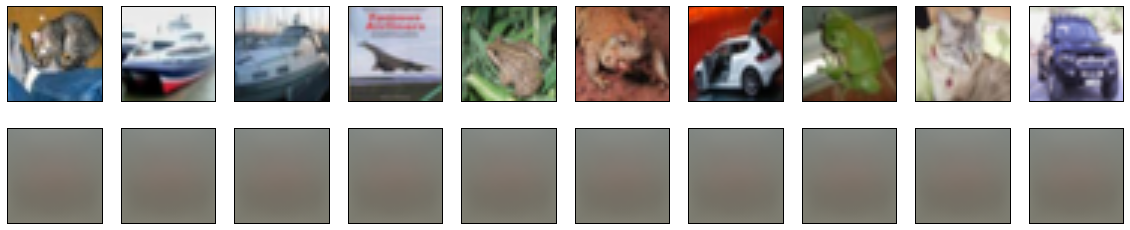

In [86]:
import matplotlib.pyplot as plt
test_res_decoded_imgs=test_res_decoded_imgs.reshape(10000,3,32,32)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    #Plot the raw original image
    plt.imshow(x_test[i].reshape(32,32,3)) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_res_decoded_imgs[i].reshape(32,32,3))    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [87]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(train_res_encoded_imgs, np.ravel(y_train))

In [88]:
y_pred = clf.predict(test_res_encoded_imgs)


In [89]:
num=len(test_res_encoded_imgs)
r=0
w=0
y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  2327 wrong:  7673 error rate:  76.73 %
got correctly  23.27 %


In [31]:
y_pred

array([5, 8, 9, ..., 3, 6, 2], dtype=uint8)

In [32]:
y_test

array([3, 8, 8, ..., 5, 1, 7])

In [ ]:
matrix_a = np.array([[15., 27., 360.],[180., 265., 79.]])
print(matrix_a.shape)
matrix_b = matrix_a/5
print(matrix_b)
